In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
import operator
import warnings
warnings.filterwarnings('ignore')
import os
from queue import PriorityQueue

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3
BATCH_SIZE = 3

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'PAD', 1: 'SOS', 2:'EOS', 3:'UNK'}#Dict
        self.n_words = 4  # Count SOS and EOS +(batch: pad and unk)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

#Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #This line is commented out since it will not properly deal with Chinese Letters
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# def readLangs(lang1, lang2, reverse=False):
#     print("Reading lines...")

#     # Read the file and split into lines
#     lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
#         read().strip().split('\n')

#     # Split every line into pairs and normalize
#     pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

#     # Reverse pairs, make Lang instances
#     if reverse:
#         pairs = [list(reversed(p)) for p in pairs]
#         input_lang = Lang(lang2)
#         output_lang = Lang(lang1)
#     else:
#         input_lang = Lang(lang1)
#         output_lang = Lang(lang2)

#     return input_lang, output_lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_TOKEN)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

## Data preprocess for Project Data
----


In [3]:
def readLangs(lang1, lang2, category, reverse = False):#category = ['train', 'dev','test]
    print('Reading lines:')
    lines1 = open('data/iwslt-' + lang1 +'-en/' + category +'.tok.'+ lang1, encoding = 'utf-8').\
    read().strip().split('\n')
    data1 = [normalizeString(l) for l in lines1]
    
    lines2 = open('data/iwslt-' + lang1 +'-en/' + category + '.tok.' + lang2, encoding = 'utf-8').\
    read().strip().split('\n')
    data2 = [normalizeString(l) for l in lines2]
    #Given that data2 is english hence we further normalize
    data2 = [re.sub(r"[^a-zA-Z.!?]+", r" ", data) for data in data2]
    print('Generating pairs')
    pairs = [[data1[i], data2[i]] for i in range(len(data1))]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


In [4]:
#Data Preparation for CHN to ENG
def prepareData(lang1, lang2, category, reverse = False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, category, reverse)
    print('Read %s sentence pairs' % len(pairs))
    #Build the vocabulary
    print('Counting words')
    #max_length = 0
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        #Get the maximum legnth 
        #pair_max = max(len(list(filter(None, pair[0].split(' ')))),
          #             len(list(filter(None, pair[1].split(' ')))))
        #max_length = max(pair_max, max_length)
        
    #Test for basic info about the data
    print('Counted Words')
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, train_pairs = prepareData('zh', 'en', 'train')
print(random.choice(train_pairs))

Reading lines:
Generating pairs
Read 213376 sentence pairs
Counting words
Counted Words
zh 88426
en 50970
['盖亚 的 整个 假说 就是   生命 为 其 本身 使 世界 更 美好     周五 五下 下午 在 洛杉矶 高速 高速公路 公路 路上 开过 车 的 任何 任何人 何人   都 相信 盖亚 假说 吗   不是', 'this whole gaia idea that life makes the world better for itself anybody been on a freeway on a friday afternoon in los angeles believing in the gaia theory ? no .']


In [5]:
input_zh, output_zh_en, train_zh_pairs = prepareData('zh', 'en', 'train')
_,_, val_zh_pairs = prepareData('zh', 'en', 'dev')
_,_, test_zh_pairs = prepareData('zh','en','test')

Reading lines:
Generating pairs
Read 213376 sentence pairs
Counting words
Counted Words
zh 88426
en 50970
Reading lines:
Generating pairs
Read 1261 sentence pairs
Counting words
Counted Words
zh 6133
en 3671
Reading lines:
Generating pairs
Read 1397 sentence pairs
Counting words
Counted Words
zh 5214
en 3220


In [6]:
input_vi, output_vi_en, train_vi_pairs = prepareData('vi', 'en', 'train')
_,_, val_vi_pairs = prepareData('vi', 'en', 'dev')
_,_, test_vi_pairs = prepareData('vi','en','test')

Reading lines:
Generating pairs
Read 133317 sentence pairs
Counting words
Counted Words
vi 30768
en 41272
Reading lines:
Generating pairs
Read 1268 sentence pairs
Counting words
Counted Words
vi 3050
en 3572
Reading lines:
Generating pairs
Read 1553 sentence pairs
Counting words
Counted Words
vi 2899
en 3408


In [7]:
train_vi_pairs[1000]

['vi_vay chung_ta nen dung ngay su u_me nay lai , dung su tho_o , dung su ky_thi che_nhao , va dung su im_lang nay , va pha_bo nhung đieu cam ky , nhin thang vao su_that , va bat_đau tro_chuyen , boi_vi cach duy_nhat đe đanh_bai mot van_đe ma ca_nhan moi nguoi phai tu minh chien_đau đo la cung manh_me vung_vang đung_lai gan nhau , cung manh_me vung_vang đung_lai gan nhau  .',
 'so we need to stop the ignorance stop the intolerance stop the stigma and stop the silence and we need to take away the taboos take a look at the truth and start talking because the only way we apos re going to beat a problem that people are battling alone is by standing strong together by standing strong together .']

In [8]:
train_zh_pairs[419]

['作为 领导 领导人   我们 不可 可能 总是 对 的', 'we apos re not always right as leaders .']

In [9]:
# #Data Preparation for Eng to FRA
# def prepareData(lang1, lang2, reverse=False):
#     input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
#     print("Read %s sentence pairs" % len(pairs))
#     pairs = filterPairs(pairs)
#     print("Trimmed to %s sentence pairs" % len(pairs))
#     print("Counting words...")
#     for pair in pairs:
#         input_lang.addSentence(pair[0])
#         output_lang.addSentence(pair[1])
#     print("Counted words:")
#     print(input_lang.name, input_lang.n_words)
#     print(output_lang.name, output_lang.n_words)
#     return input_lang, output_lang, pairs


# input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
# print(random.choice(pairs))

In [6]:
class NMTDataset(Dataset):
    def __init__(self, pairs, input_lang, output_lang):#Needs the index pairs
        self.pairs = pairs
        self.input_lang = input_lang
        self.output_lang = output_lang
        self.input_seqs = [pairs[i][0] for i in range(len(self.pairs))]
        self.output_seqs = [pairs[i][1] for i in range(len(self.pairs))]

    def __len__(self):
        return len(self.pairs)#Returning number of pairs
    
    def __getitem__(self, index):
        input_seq = self.input_seqs[index]
        output_seq = self.output_seqs[index]
        return [input_seq, len(input_seq), output_seq, len(output_seq)]
    
def vocab_collate_func(batch):
    #Reference: lab8_3_mri
    def _pad_sequences(seqs):
        lens = [len(seq) for seq in seqs]
        padded_seqs = torch.zeros(len(seqs), max(lens)).long()
        for i, seq in enumerate(seqs):
            end = lens[i]
            padded_seqs[i, :end] = torch.LongTensor(seq[:end])
        return padded_seqs, lens
    
    batch_input_seqs = [datum[0] for datum in batch]
    batch_output_seqs = [datum[2] for datum in batch]
    #batch_input_length = [datum[1] for datum in batch]
    #batch_output_length = [datum[3] for datum in batch]

    sorted_pairs = sorted(zip(batch_input_seqs, batch_output_seqs), key=lambda x: len(x[0]), reverse = True)
    in_seq_sorted, out_seq_sorted = zip(*sorted_pairs)
    
    padded_input,input_lens = _pad_sequences(in_seq_sorted)
    padded_output,output_lens = _pad_sequences(out_seq_sorted)
    
    return [torch.from_numpy(np.array(padded_input)).to(device),
            torch.LongTensor(input_lens).to(device),
            torch.from_numpy(np.array(padded_output)).to(device),
            torch.LongTensor(output_lens).to(device)]

In [64]:
index_zh_pairs = [[indexesFromSentence(input_zh, train_zh_pairs[i][0]),
                indexesFromSentence(output_zh_en, train_zh_pairs[i][1])] for i in range(len(train_zh_pairs))]
#index_pairs = indexesFromPair(pair)

'''
NMTDataset needs index pairs, need to call indexesFromPairs functions beforehand
The dataLoader is sorted according to length of the input_length, and padded to
max length of input and output list repectively
TODO: output_list is not sorted, hence need to sort (maybe) in the rnn sequence.
'''
train_dataset = NMTDataset(index_zh_pairs, input_lang, output_lang)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                          batch_size = BATCH_SIZE,
                                          collate_fn = vocab_collate_func,
                                          shuffle = True)
#Input_batch in size Batch x maxLen


In [65]:
#Test for batch sizes
for i, (input_list, input_length, output_list, output_length) in enumerate(train_loader):
    if i== 0:
        break

In [66]:
input_length

tensor([27, 27, 10], device='cuda:0')

## Encoder and Decoder w/ Attn(batch)

In [67]:
#Here for the constant definition
MAX_SENTENCE_LENGTH = 10
hidden_size = 256
max_length = 10
BATCH_SIZE = 3
TEST_BATCH_SIZE = 3


### RNN Encoder

In [68]:
class BatchEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, n_layers=1, dropout=0.1):
        super(BatchEncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional = True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        '''
        input_seqs in size B x L sorted in decreasing order -> will transpose to fit in embedding dimension
        '''
        embedded = self.embedding(input_seqs.transpose(0,1))#input_seqs B x L -> transpose to L x B
        #Input length sorted by loader
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        #Outputs in shape L x B x 2H, hidden as the last state of the GRU
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        #hidden = hidden[:self.n_layers, :, :] + hidden[self.n_layers:,:,:]#Sum bidrectional information
        #outputs L x B x H
        #hidden size (2*n_layers) x B x H

        #outputs: seq_len x Batch x H
        return outputs, hidden
    
    def initHidden(self):
        return torch.zeros(self.n_layers *2, self.batch_size, self.hidden_size,device = device)#hidden size 2lays *B*H

In [69]:
batch_encoder = BatchEncoderRNN(input_lang.n_words, hidden_size, BATCH_SIZE, n_layers = 2, dropout = 0.1).to(device)
init_hidden = batch_encoder.initHidden()
encoder_outputs, encoder_hidden = batch_encoder(input_list, input_length, init_hidden)
#inithidden bidirectional, encoder_hidden, summing up both directions
init_hidden.size(), encoder_outputs.size(), encoder_hidden.size()

(torch.Size([4, 3, 256]), torch.Size([27, 3, 256]), torch.Size([4, 3, 256]))

### RNN Decoder w/o attention

In [70]:
# RNN decoder with no attention used, batch implemented
class DecoderRNN(nn.Module):
    def __init__(self, emb_size, hidden_size, output_size, batch_size, n_layers=1, dropout_p = 0.1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.emb_size = emb_size
        self.batch_size = batch_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(dropout_p)
        self.embedding = nn.Embedding(output_size, emb_size,padding_idx = PAD_TOKEN)
        self.gru = nn.GRU(emb_size, hidden_size, n_layers, dropout = dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        embedded = self.dropout(embedded)
        output = F.relu(embedded)
        output, hidden = self.gru(output, hidden)#output 1 x B x E, hidden n_layers x B x H
        out = self.out(output[0])
        out = self.softmax(out)
        #out size batch x output_lang vocab size
        #hidden n_layers x B x H
        return out, hidden
    
#     def initHidden(self):
#         return torch.zeros(self.n_layers, self.batch_size, self.hidden_size, device = device)

### RNN Decoder with Attention

In [71]:
#Reference: lab8 3_mri, Luong model
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            #self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))
    
    def forward(self, hidden, encoder_outputs):
        # Create variable to store attention energies
        # For each batch of encoder outputs Calculate energy for each encoder output
        beta = self.score(hidden, encoder_outputs)#Len x Batch
        #print('The size for beta is {}'.format(beta.size()))
        alpha = F.softmax(beta.transpose(0,1)).unsqueeze(1)#B x 1 x L
        #encoder_ouputs L x B x H originally -> transpose to B x L x H
        #alpha bmm encoder_outputs: B x 1 x L bmm B x L x H -> B x 1 x N
        context = alpha.bmm(encoder_outputs.transpose(0,1))#B X 1 X N        
        
        # Return context vectors and attnetion weights for visualization
        return context, alpha
    
    def score(self, hidden, encoder_outputs):
        
        if self.method == 'dot':
            ## TODO implement
            energy = torch.sum(hidden*encoder_outputs, 2)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_outputs)
            ## TODO implement 
            energy = torch.sum(hidden*energy,2)
            return energy
        
        elif self.method == 'concat':
            cat = torch.cat((hidden.repeat(encoder_outputs.size(0), 1,1),encoder_outputs),dim=2)
            energy = F.tanh(self.attn(cat))
            ## TODO implement 
            energy = torch.sum(self.v * energy, 2)
            return energy

In [72]:
#Reference Lab8 3-mri, Luong model
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=PAD_TOKEN)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x H

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        context, alpha = self.attn(rnn_output, encoder_outputs)

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)
        #Softmax to get the distribution
        output = F.softmax(output, dim=1)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, alpha

In [73]:
attn_model = 'dot'
decoder_test = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers=2, dropout=0.1).to(device)
decoder_input = torch.tensor([[SOS_TOKEN]], device=device).repeat(TEST_BATCH_SIZE,1)
decoder_hidden = encoder_hidden[:decoder_test.n_layers]
#decoder_hidden = encoder_hidden
input_seq = decoder_input
last_hidden = decoder_hidden
# attn_model = 'dot'
print(decoder_input.size(), decoder_hidden.size())
# decoder_test = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers=2, dropout=0.1).to(device)
decoder_output, decoder_hidden, attn_weights = decoder_test(decoder_input, decoder_hidden, encoder_outputs)

#Test rounds
all_decoder_outputs = torch.zeros(output_length.max().item(), TEST_BATCH_SIZE, decoder_test.output_size)
for t in range(output_length.max().item()):
    decoder_output, decoder_hidden, decoder_attn = decoder_test(decoder_input, decoder_hidden, encoder_outputs)
    all_decoder_outputs[t] = decoder_output
    decoder_input = output_list[:,t].unsqueeze(1)

torch.Size([3, 1]) torch.Size([2, 3, 256])


### End of Encoder and Decoder session

In [74]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [75]:
# teacher_forcing_ratio = 0.5
# MAX_LENGTH = 10
# def batch_train(input_list, input_length, output_list,output_length, batch_encoder, batch_decoder, encoder_optimizer, decoder_optimizer, criterion):
#     batch_encoder.train()
#     batch_decoder.train()
#     encoder_optimizer.zero_grad()
#     decoder_optimizer.zero_grad()
#     max_output_length = output_length.max().item()


# #     input_length = input_tensor.size(0)
# #     target_length = target_tensor.size(0)

# #     encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
#     loss = 0

#     #batch_encoder = BatchEncoderRNN(input_lang.n_words, hidden_size, BATCH_SIZE, n_layers = 2, dropout = 0.1)
#     init_hidden = batch_encoder.initHidden()
#     encoder_outputs, encoder_hidden = batch_encoder(input_list, input_length, init_hidden)

#     #Initialize for decoding process
#     curr_batch = input_list.size(0)#Take the current batch size
#     decoder_input = torch.tensor([[SOS_TOKEN]], device=device).repeat(curr_batch,1)
#     decoder_hidden = encoder_hidden#Bidirectional summoned
#     #encoder_outputs : L x B x H
#     decoder_outputs = torch.zeros(max_output_length, curr_batch, batch_decoder.output_size)

#     #use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
#     use_teacher_forcing = True
#     if use_teacher_forcing:
#         # Teacher forcing: Feed the target as the next input
#         for di in range(max_output_length):
#             decoder_output, decoder_hidden, decoder_attention = batch_decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
#             decoder_outputs[di] = decoder_output
#             loss += criterion(decoder_output, output_list[:,di])
#             decoder_input = output_list[:,di].unsqueeze(1)  # Teacher forcing

#     else:
#         # Without teacher forcing: use its own predictions as the next input
#         for di in range(max_output_length):
#             decoder_output, decoder_hidden, decoder_attention = batch_decoder(
#                 decoder_input, decoder_hidden, encoder_outputs)
#             topv, topi = decoder_output.topk(1)
#             decoder_input = topi.detach()# detach from history as input: size batch x 1 

#             loss += criterion(decoder_output, output_list[:, di])
#             if ((decoder_output == EOS_TOKEN).sum().item()) == decoder_output.size(0):#If all are EOS tokens
#                 break;
            


#     loss.backward()

#     encoder_optimizer.step()
#     decoder_optimizer.step()

#     return loss.item() / max_output_length

In [76]:
teacher_forcing_ratio = 1.0
MAX_LENGTH = 10
def batch_train(input_list, input_length, output_list,output_length, batch_encoder, batch_decoder, encoder_optimizer, decoder_optimizer, criterion):
    batch_encoder.train()
    batch_decoder.train()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    max_output_length = output_length.max().item()
    


#     input_length = input_tensor.size(0)
#     target_length = target_tensor.size(0)

#     encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0

    #batch_encoder = BatchEncoderRNN(input_lang.n_words, hidden_size, BATCH_SIZE, n_layers = 2, dropout = 0.1)
    init_hidden = batch_encoder.initHidden()
    encoder_outputs, encoder_hidden = batch_encoder(input_list, input_length, init_hidden)

    #Initialize for decoding process
    curr_batch = input_list.size(0)#Take the current batch size
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device).repeat(curr_batch,1)
    decoder_hidden = encoder_hidden[:batch_decoder.n_layers]#Bidirectional summoned
    #encoder_outputs : L x B x H
    decoder_outputs = torch.zeros(max_output_length, curr_batch, batch_decoder.output_size)

    #use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    use_teacher_forcing = True
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(max_output_length):
            decoder_output, decoder_hidden, decoder_attention = batch_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs[di] = decoder_output
            loss += criterion(decoder_output, output_list[:,di])
            decoder_input = output_list[:,di].unsqueeze(1)  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(max_output_length):
            decoder_output, decoder_hidden, decoder_attention = batch_decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs[di] = decoder_input
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()# detach from history as input: size batch x 1 

            loss += criterion(decoder_output, output_list[:, di])
            if ((decoder_output == EOS_TOKEN).sum().item()) == decoder_output.size(0):#If all are EOS tokens
                break;
            

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / max_output_length

In [77]:
batch_encoder_test = BatchEncoderRNN(input_lang.n_words, hidden_size, TEST_BATCH_SIZE, n_layers = 2, dropout = 0.1).to(device)
init_hidden = batch_encoder.initHidden()
# encoder_outputs, encoder_hidden = batch_encoder_test(input_list, input_length, init_hidden)
attn_model = 'dot'
batch_decoder_test = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers=2, dropout=0.1).to(device)

learning_rate = 0.1
encoder_optimizer = optim.SGD(batch_encoder_test.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(batch_decoder_test.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()



In [78]:
loss= batch_train(input_list, input_length, output_list, output_length, 
            batch_encoder_test, batch_decoder_test, encoder_optimizer, 
           decoder_optimizer, criterion)
print(loss)

10.838990529378256


In [79]:
#Breif test on tiny batch to see whether it is working.
#Teaching forcing  always
batch_encoder_test = BatchEncoderRNN(input_lang.n_words, hidden_size, TEST_BATCH_SIZE, n_layers = 2, dropout = 0.1).to(device)
init_hidden = batch_encoder.initHidden()
# encoder_outputs, encoder_hidden = batch_encoder_test(input_list, input_length, init_hidden)
attn_model = 'general'
batch_decoder_test = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers=2, dropout=0.1).to(device)

learning_rate = 0.01
encoder_optimizer = optim.SGD(batch_encoder_test.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(batch_decoder_test.parameters(), lr=learning_rate)
#criterion = torch.nn.CrossEntropyLoss().cuda()
criterion = torch.nn.CrossEntropyLoss().to(device)

train_loss_list = []
# for i, (input_list, input_length, output_list, output_length) in enumerate(train_loader):
#     loss = batch_train(input_list, input_length, output_list, output_length, 
#             batch_encoder_test, batch_decoder_test, encoder_optimizer, 
#            decoder_optimizer, criterion)
#     train_loss_list.append(loss)
#     print(loss)
for i in range(1000):
    loss = batch_train(input_list, input_length, output_list, output_length, 
            batch_encoder_test, batch_decoder_test, encoder_optimizer, 
           decoder_optimizer, criterion)
    train_loss_list.append(loss)
    print(loss)

10.83899180094401
10.838990529378256
10.838990529378256
10.838990529378256
10.838990529378256
10.838990529378256
10.83899180094401
10.838990529378256
10.838990529378256
10.838990529378256
10.838990529378256
10.838990529378256
10.838990529378256
10.83899180094401
10.838990529378256
10.83899180094401
10.838990529378256
10.838990529378256


KeyboardInterrupt: 

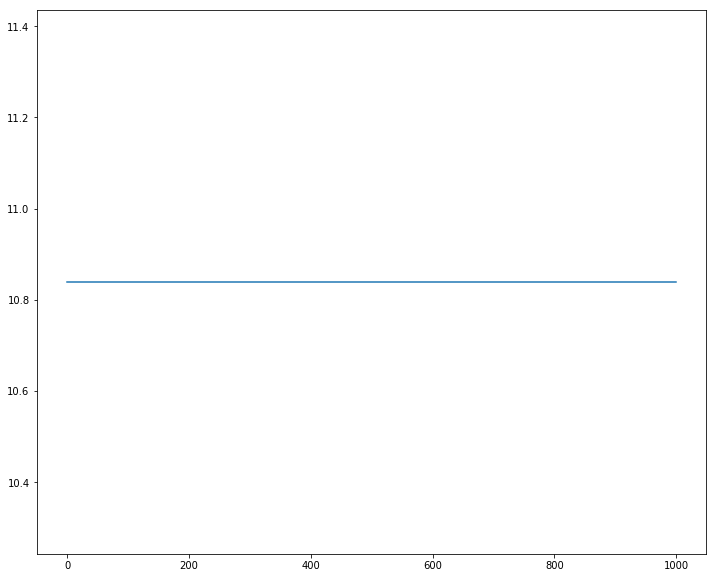

In [36]:
fig, ax = plt.subplots(figsize = (12,10))
ax.plot(train_loss_list)


In [41]:
checkpoint_dir = os.getcwd()

#Reference: lab8 3_mri
def save_checkpoint(encoder, decoder, checkpoint_dir):
    enc_filename = "{}/enc-{}.pth".format(checkpoint_dir, time.strftime("%d%m%y-%H%M%S"))
    dec_filename = "{}/dec-{}.pth".format(checkpoint_dir, time.strftime("%d%m%y-%H%M%S"))
    torch.save(encoder.state_dict(), enc_filename)
    torch.save(decoder.state_dict(), dec_filename)
    print("Model saved.")

def train(train_dataset, batch_size, n_epochs, batch_encoder, batch_decoder, 
          encoder_optimizer, decoder_optimizer, criterion, 
          checkpoint_dir=None, save_every=500):
    '''
    Call batch_train  inside trian
    '''
    
    train_loader = DataLoader(dataset = train_dataset, 
                              batch_size = batch_size,
                              collate_fn = vocab_collate_func,
                              shuffle = True)
    for i in range(n_epochs):
        tick = time.clock()
        print("Epoch {}/{}".format(i+1, n_epochs))
        losses = []
        for batch_idx, batch in enumerate(train_loader):
            input_list, input_length, output_list, output_length = batch
            loss = batch_train(input_list, input_length, output_list, output_length, 
                                batch_encoder, batch_decoder, encoder_optimizer, 
                              decoder_optimizer, criterion)
            losses.append(loss)          
            
            if batch_idx % 100 == 0:
                print("batch: {}, loss: {}".format(batch_idx, loss))
            if checkpoint_dir:
                if batch_idx % save_every == 0:
                    save_checkpoint(batch_encoder, batch_decoder, checkpoint_dir)
        
        tock = time.clock()
        print("Time: {} Avg loss: {}".format(tock-tick, np.mean(losses)))
    
    if checkpoint_dir:
        save_checkpoint(batch_encoder, batch_decoder, checkpoint_dir)

In [42]:
def sentenceFromTensor(tensor, lang):
    seq_idx = tensor.data.cpu().numpy()#A single sentence 
    seq_word = [lang.index2word[seq_idx[i]] for i in range(len(seq_idx))]
    return seq_word
    
def batch_translate(decoded_batch, lang):
    translated_batch = []
    for i in range(decoded_batch.shape[0]):
        translated_batch.append(sentenceFromTensor(decoded_batch[i], lang))
    return translated_batch

In [43]:
def greedy_evaluate(input_list, input_length, encoder, decoder, lang, max_length=MAX_LENGTH):
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
#         input_tensor = tensorFromSentence(input_lang, input_list)
#         input_length = input_tensor.size()[0]
        # encode the source lanugage
        max_input_length = input_length.max().item()
        encoder_outputs = torch.zeros(batch_size, max_length, max_input_length, device=device)

        encoder_outputs, encoder_hidden = encoder(input_list, input_length, None)
        
        decoder_input = torch.tensor([SOS_TOKEN]*batch_size, device=device)  # SOS
        # decode the context vector
        decoder_hidden = encoder_hidden[:decoder.n_layers] # decoder starts from the last encoding sentence
        # output of this function
        decoded_batch = torch.zeros((batch_size, max_length))#batch x sentence length
        decoder_attentions = torch.zeros(max_length, batch_size, max_input_length)#in length, each position has attention
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #decoder_attention: B x L
            decoder_attentions[di] = decoder_attention.squeeze(1)
            topv, topi = decoder_output.data.topk(1)  # get candidates
            topi = topi.view(-1)
            decoded_batch[:, di] = topi#Still indexes

            decoder_input = topi.detach()

        #return decoded_words, decoder_attentions[:di + 1]
        decoded_words = batch_translate(decoded_batch, lang)
        return decoded_words, decoded_batch, decoder_attentions

In [44]:
def test_model_score(val_loader, encoder, decoder, max_length, search_method = 'greedy', target_lang='zh'):
    encoder.eval()
    decoder.eval()
    total = 0
    total_loss = 0
    predict_file = 'predict_temp'
    predict_lines = open(predict_file, 'w')
    for i, (input_list, input_length, output_list, output_length) in enumerate(val_loader):
        loss = batch_train(
            input_list, input_length, output_list, output_length,
            encoder, decoder,
            encoder_optimizer, decoder_optimizer, criterion
        )
        if search_method == 'greedy':
            decoded_words, decoded_list, decoder_attention = greedy_evaluate(input_list, input_length,
                                                                            encoder, decoder, target_lang,
                                                                            max_length = max_length)
        else:
            decoded_words, decoded_list, decoder_attention = beam_evaluate(input_list)
        
        total_loss += loss
        total += 1
        predict_lines.write(''.join(decoded_words) + '\n')
    predict_lines.close()
        
    if target_lang == 'zh':
        target_file = 'iwslt-zh-en-processed/test.tok.en'
    else:
        target_file = 'iwslt-vi-en-processed/test.tok.en'
    result = subprocess.run('cat {} | sacrebleu {}'.format(predict_file,target_file),shell=True,stdout=subprocess.PIPE)
    score = get_blue_score(str(result))
        
    return (total_loss / total), score

#### Beam Search:

In [225]:
class SearchNode(object):
    def __init__(self, word_idx, hidden, prev, curr_score, length):
        self.hidden = hidden
        self.word_idx = word_idx
        self.prev = prev
        
        if self.prev == None:
            self.score = curr_score
        else:
            self.score = self.prev.score + curr_score
        self.length = length


In [226]:
def beam_search(decoder_hiddens, encoder_outputs, batch_decoder, batch_size, beam_width, attn_flag, k):
    '''
    beam_width: number of best nodes kept at each iterations
    k: number of sentences we want to keep
    Returns the translated batch
    '''
    decoded_batch = []
    #decoder_attentions = torch.zeros(max_length, batch_size, max_input_length)#in length, each position has attention

    
    for idx in range(batch_size):
        #Take the certain batch hidden layer
        decoder_hidden = decoder_hiddens[:, idx, :].unsqueeze(1)#1 x layers x H
        encoder_output = encoder_outputs[:, idx, :].unsqueeze(1)#L x 1 x H
        
        decoder_input = torch.LongTensor([SOS_TOKEN], device = device)
        start_node = SearchNode(decoder_input, decoder_hidden, prev = None, curr_score = 0, length = 1)
        nodes = PriorityQueue()
        nodes.put(( -(start_node.score), start_node))
        end_nodes = []
        
        while(len(end_nodes) < k):
            curr_score, curr_node = nodes.get()

            if (curr_node.word_idx == EOS_TOKEN) and (curr_node.prev != None):
                endnodes.append((-(curr_node.score),curr_node))
                if len(end_nodes) >=k:
                    break;
                else: 
                    continue;
                    
            if nodes.qsize() >= 2000:#if too long will force to stop
                #Create an EOS dummy node to trace back the entire sentence
                EOS_node = SearchNode(torch.tensor([[EOS_TOKEN]], device = device), curr_node.hidden, 
                                      curr_node, curr_node.score, (curr_node.length)+1)
                end_nodes.append((-(EOS_node.score), EOS_node))
                if len(end_nodes) >= k:
                    break;
                else:
                    continue;
                    
            decoder_input = curr_node.word_idx
            decoder_hidden = curr_node.hidden
            
            if attn_flag :
                decoder_output, decoder_hidden, decoder_attention = batch_decoder(decoder_input, decoder_hidden, 
                                                                            encoder_output)
            else:
                decoder_output, decoder_hidden = batch_decoder(deocder_input, decoder_hidden,encoder_output)
                
            scores, indexes = torch.topk(decoder_output, beam_width)
            candidate_nodes = []
            for i in range(beam_width):
                candidate_idx = indexes[0][i].view(1, -1)
                candidate_score = scores[0][i].item()
                
                candidate_node = SearchNode(candidate_idx, decoder_hidden, 
                                               curr_node, candidate_score, curr_node.length + 1)
                candidate_nodes.append((-(candidate_node.score), candidate_node))
            
            for j in range(beam_width):
                to_push_score, to_push_node = candidate_nodes[j]
                #print(to_push_score)
                nodes.put((-(to_push_score), to_push_node))
            #End of the while loop
            
        sentences = translate_end_nodes(end_nodes)
        decoded_batch.append(sentences)
        #End of the batch loop
        
    return decoded_batch

In [227]:
#Translate the sentences.
def translate_end_nodes(end_nodes):
    sentences = []
    end_nodes = sorted(end_nodes, key = operator.itemgetter(0),reverse = True)
    for _, end_node in end_nodes:
        sentence = []
        while end_node.prev != None:
            sentence.append(output_lang.index2word[end_node.word_idx.item()])
            end_node = end_node.prev
        sentence = sentence[::-1]#Reverse the sentence to get the sentence
        sentences.append(sentence)
    return sentences

In [228]:
batch_encoder = BatchEncoderRNN(input_lang.n_words, hidden_size, BATCH_SIZE, n_layers = 2, dropout = 0.1)
init_hidden = batch_encoder.initHidden()
encoder_outputs, encoder_hidden = batch_encoder(input_list, input_length, init_hidden)
#inithidden bidirectional, encoder_hidden, summing up both directions
print(init_hidden.size(), encoder_outputs.size(), encoder_hidden.size())

decoded_batches = beam_search(decoder_hidden, encoder_outputs, batch_decoder_test, TEST_BATCH_SIZE, 5, True, 1)
decoded_batches

torch.Size([4, 3, 256]) torch.Size([48, 3, 256]) torch.Size([4, 3, 256])


[[['rounds', 'possession', 'fraudsters', 'conditionally', 'EOS']],
 [['strangled', 'ramona', 'knowing', 'cow', 'EOS']],
 [['unscrew', 'whispers', 'causes', 'cavendish', 'EOS']]]